<a href="https://colab.research.google.com/github/mj-codes-web/lung-colon-cancer-CNN-/blob/main/lung_colon_cancer(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
# Generate data paths with labels
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/kaggle/input/lung-and-colon-cancer-histopatho...,Colon Adenocarcinoma
1,/kaggle/input/lung-and-colon-cancer-histopatho...,Colon Adenocarcinoma
2,/kaggle/input/lung-and-colon-cancer-histopatho...,Colon Adenocarcinoma
3,/kaggle/input/lung-and-colon-cancer-histopatho...,Colon Adenocarcinoma
4,/kaggle/input/lung-and-colon-cancer-histopatho...,Colon Adenocarcinoma
...,...,...
24995,/kaggle/input/lung-and-colon-cancer-histopatho...,Lung Benign Tissue
24996,/kaggle/input/lung-and-colon-cancer-histopatho...,Lung Benign Tissue
24997,/kaggle/input/lung-and-colon-cancer-histopatho...,Lung Benign Tissue
24998,/kaggle/input/lung-and-colon-cancer-histopatho...,Lung Benign Tissue


In [ ]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
# crobed image size
batch_size = 16
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


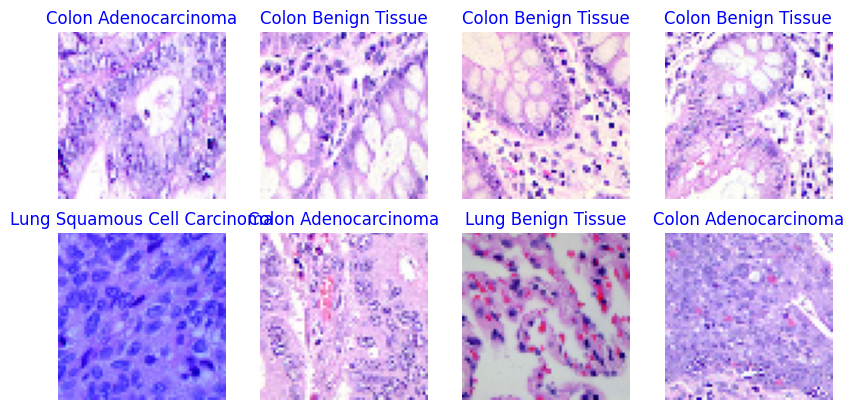

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (10, 10))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create Model Structure
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
epochs = 3   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.4206 - loss: 1.9414 - val_accuracy: 0.8224 - val_loss: 0.4262
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1681s 1s/step - accuracy: 0.8155 - loss: 0.4591 - val_accuracy: 0.8956 - val_loss: 0.2675
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1704s 1s/step - accuracy: 0.8998 - loss: 0.2719 - val_accuracy: 0.9352 - val_loss: 0.1930


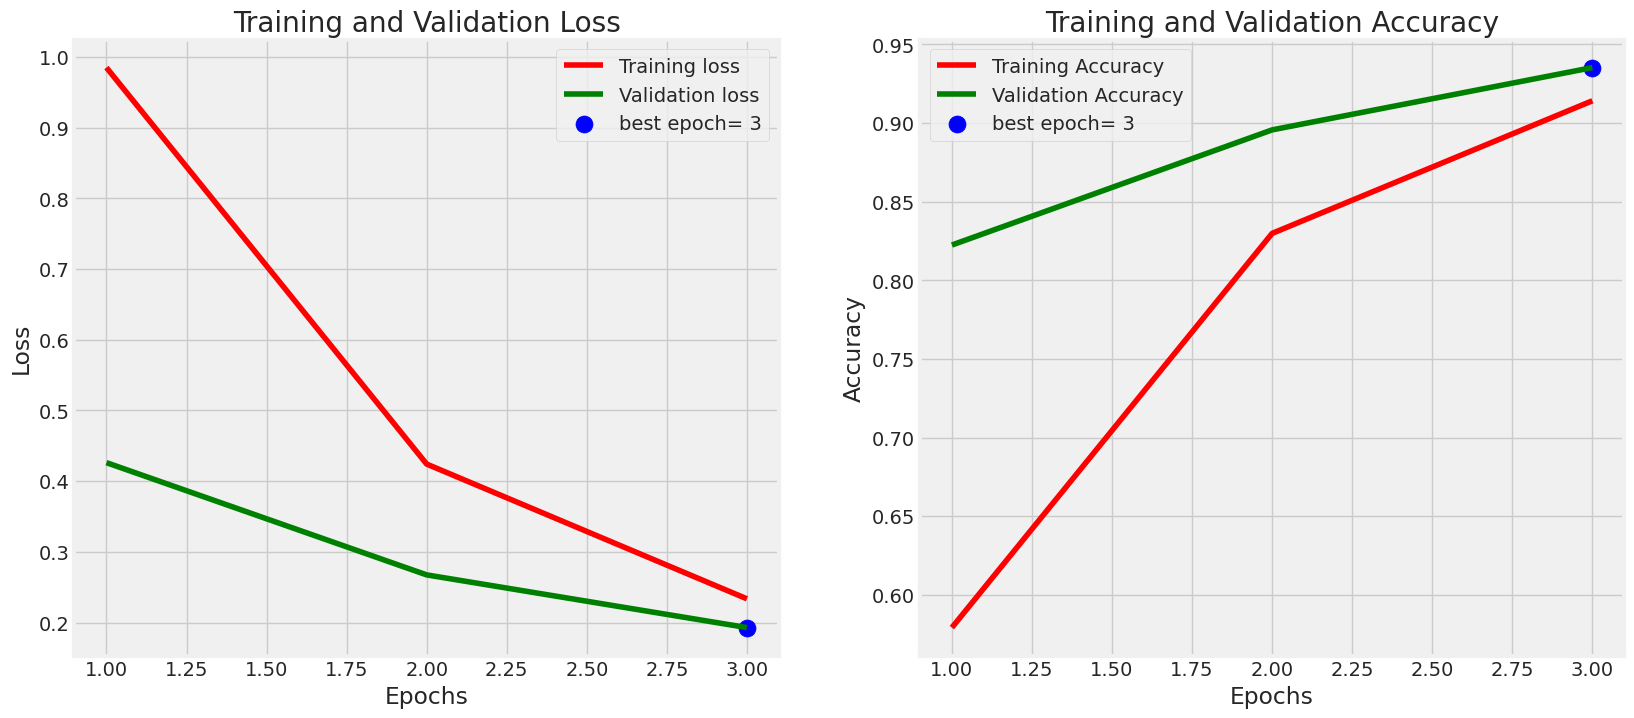

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.9355 - loss: 0.2307
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step - accuracy: 0.9414 - loss: 0.2012
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 351ms/step - accuracy: 0.9325 - loss: 0.2016
Train Loss:  0.21782703697681427
Train Accuracy:  0.9312499761581421
--------------------
Valid Loss:  0.1912972778081894
Valid Accuracy:  0.9362499713897705
--------------------
Test Loss:  0.1902042031288147
Test Accuracy:  0.9399999976158142


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step


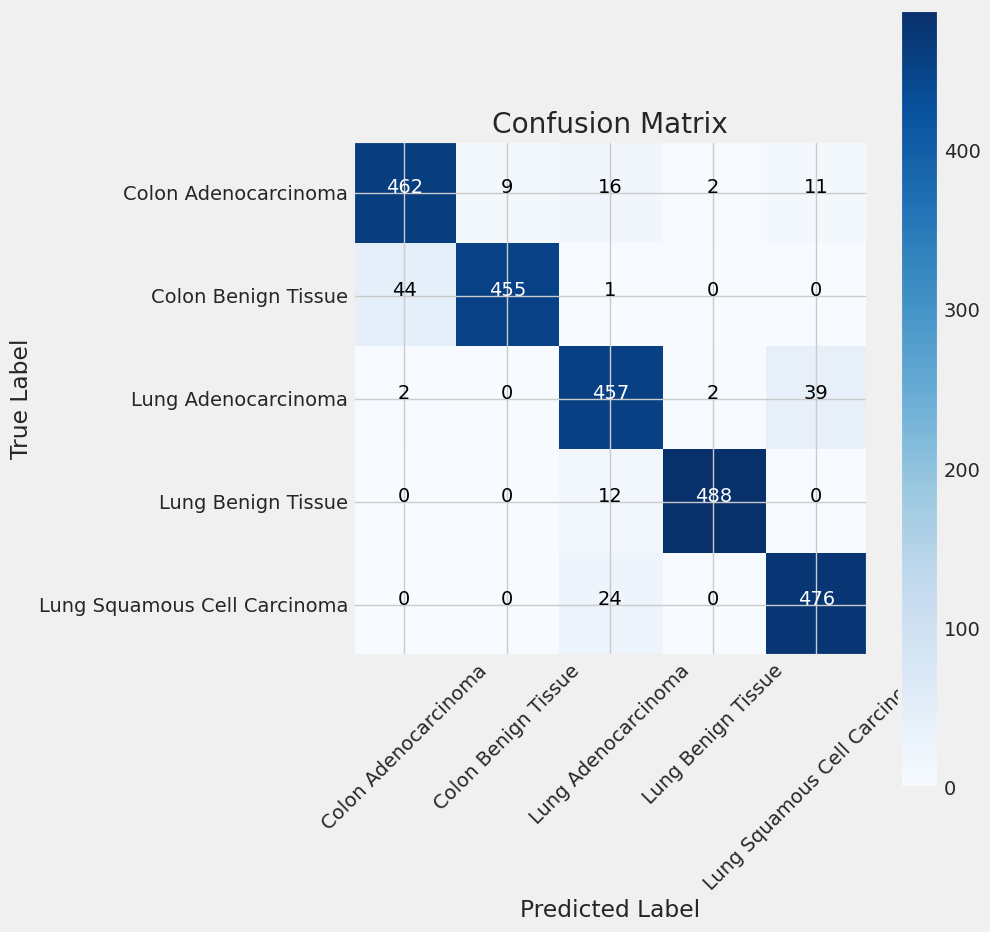

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.91      0.92      0.92       500
         Colon Benign Tissue       0.98      0.91      0.94       500
         Lung Adenocarcinoma       0.90      0.91      0.90       500
          Lung Benign Tissue       0.99      0.98      0.98       500
Lung Squamous Cell Carcinoma       0.90      0.95      0.93       500

                    accuracy                           0.94      2500
                   macro avg       0.94      0.94      0.94      2500
                weighted avg       0.94      0.94      0.94      2500



In [ ]:
#Save the model
model.save('Model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((64, 64))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Lung Adenocarcinoma


In [ ]:
# Function to build the model
def build_model():
    model = Sequential([
        Conv2D(64, (3,3), padding="same", activation="relu", input_shape=img_shape),
        Conv2D(64, (3,3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3,3), padding="same", activation="relu"),
        Conv2D(128, (3,3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3,3), padding="same", activation="relu"),
        Conv2D(256, (3,3), padding="same", activation="relu"),
        Conv2D(256, (3,3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3,3), padding="same", activation="relu"),
        Conv2D(512, (3,3), padding="same", activation="relu"),
        Conv2D(512, (3,3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3,3), padding="same", activation="relu"),
        Conv2D(512, (3,3), padding="same", activation="relu"),
        Conv2D(512, (3,3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation="relu"),
        Dense(64, activation="relu"),
        Dense(class_count, activation="softmax")
    ])
    return model


In [ ]:
learning_rates = [0.1, 0.01, 0.001]
results = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = build_model()
    model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, epochs=1, validation_data=valid_gen, verbose=1)

    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    results.append({'Learning Rate': lr, 'Test Accuracy': round(test_acc * 100, 2)})

# Display results in a table
results_df = pd.DataFrame(results)
print("\nLearning Rate Comparison:")
print(results_df)

# Optional: plot results
plt.figure(figsize=(6, 4))
sns.barplot(x="Learning Rate", y="Test Accuracy", data=results_df, palette="Blues_d")
plt.title("Test Accuracy at Different Learning Rates")
plt.ylim(0, 100)
plt.show()


In [ ]:
def build_optimized_model():
    model = Sequential([
        Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001), input_shape=img_shape),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Conv2D(128, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(class_count, activation='softmax')
    ])

    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Image shape
img_shape = (64, 64, 3)

# Data generators with augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Automatically detect class labels
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Model definition
def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=img_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Try different learning rates
learning_rates = [0.1, 0.01, 0.001]
results = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = build_model(num_classes)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator, epochs=3, validation_data=val_generator, verbose=1)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    results.append((lr, val_acc))

# Print accuracy results
print("\nValidation Accuracy at Different Learning Rates:")
for lr, acc in results:
    print(f"Learning Rate: {lr:.3f} --> Accuracy: {acc:.4f}")


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

Training with learning rate: 0.1
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 285s 226ms/step - accuracy: 0.5781 - loss: 139.7555 - val_accuracy: 0.6000 - val_loss: 0.6731
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.5986 - loss: 0.6779 - val_accuracy: 0.6000 - val_loss: 0.6734
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.5931 - loss: 0.6782 - val_accuracy: 0.6000 - val_loss: 0.6733

Training with learning rate: 0.01
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - accuracy: 0.7213 - loss: 0.7282 - val_accuracy: 0.6000 - val_loss: 0.6731
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 111ms/step - accuracy: 0.5980 - loss: 0.6728 - val_accuracy: 0.6000 - val_loss: 0.6739
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.5993 - loss: 0.6745 - val_accuracy: 0.6000 - val_loss: 0.6743

Training with learning rate: 0.001
Epoch 1/3


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
import pandas as pd

# Set image input shape
img_shape = (64, 64, 3)

# Data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Auto-detect number of classes
num_classes = train_generator.num_classes

# Build CNN model
def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=img_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define optimizers
optimizer_dict = {
    "SGD": SGD,
    "Adam": Adam,
    "RMSprop": RMSprop,
    "Adagrad": Adagrad
}

learning_rates = [0.1, 0.01, 0.001]

# Store results
results = []

# Training loop
for opt_name, opt_class in optimizer_dict.items():
    for lr in learning_rates:
        print(f"\nTraining with {opt_name} (lr={lr})")

        model = build_model(num_classes)
        optimizer = opt_class(learning_rate=lr)

        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.fit(train_generator, epochs=3, validation_data=val_generator, verbose=1)
        val_loss, val_acc = model.evaluate(val_generator, verbose=0)

        results.append({
            'Optimizer': opt_name,
            'Learning Rate': lr,
            'Validation Accuracy': val_acc
        })

# Display results as table
results_df = pd.DataFrame(results)
print("\n📊 Validation Accuracy Results:")
print(results_df)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

Training with SGD (lr=0.1)
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 300s 238ms/step - accuracy: 0.6231 - loss: 0.6657 - val_accuracy: 0.6000 - val_loss: 0.6746
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 157s 125ms/step - accuracy: 0.5997 - loss: 0.6742 - val_accuracy: 0.6000 - val_loss: 0.6734
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 126ms/step - accuracy: 0.5981 - loss: 0.6746 - val_accuracy: 0.6000 - val_loss: 0.6756

Training with SGD (lr=0.01)
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 160s 127ms/step - accuracy: 0.7580 - loss: 0.4748 - val_accuracy: 0.9674 - val_loss: 0.0901
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 124ms/step - accuracy: 0.9607 - loss: 0.1233 - val_accuracy: 0.9592 - val_loss: 0.0972
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 124ms/step - accuracy: 0.9795 - loss: 0.0597 - val_accuracy: 0.9598 - val_loss: 0.0963

Training with SGD (lr=0.001)
Epoch 1/3
1250/1250 ━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Image input size for MobileNetV2
img_size = (64, 64)
input_shape = img_size + (3,)

# Data generators with validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Number of output classes
num_classes = train_generator.num_classes

# Build model using MobileNetV2
def build_model():
    try:
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        print("✅ Loaded pre-trained weights.")
    except:
        base_model = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
        print("⚠️ Loaded model without pre-trained weights.")

    base_model.trainable = False  # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile and train
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    verbose=1
)

# Evaluate
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"\n📊 Final Validation Accuracy: {val_acc:.4f}")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
⚠️ Loaded model without pre-trained weights.
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 110ms/step - accuracy: 0.5946 - loss: 0.6833 - val_accuracy: 0.6000 - val_loss: 0.6731
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.5994 - loss: 0.6737 - val_accuracy: 0.6000 - val_loss: 0.6730
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 109ms/step - accuracy: 0.5977 - loss: 0.6742 - val_accuracy: 0.6000 - val_loss: 0.6730

📊 Final Validation Accuracy: 0.6000


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

🔍 Training VGG16 at learning rate 0.1...
⚠️ Loaded VGG16 without pre-trained weights (offline mode).
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 542s 431ms/step - accuracy: 0.5859 - loss: 0.6816 - val_accuracy: 0.6000 - val_loss: 0.6731
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 543s 433ms/step - accuracy: 0.5944 - loss: 0.6778 - val_accuracy: 0.6000 - val_loss: 0.6752
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 542s 433ms/step - accuracy: 0.5883 - loss: 0.6805 - val_accuracy: 0.6000 - val_loss: 0.6737

🔍 Training VGG16 at learning rate 0.01...
⚠️ Loaded VGG16 without pre-trained weights (offline mode).
Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 553s 440ms/step - accuracy: 0.7910 - loss: 0.4255 - val_accuracy: 0.9252 - val_loss: 0.1810
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 537s 429ms/step - accuracy: 0.9522 - loss: 0.1340 - val_accuracy: 0.9524 - val_loss: 0.1250
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 551s

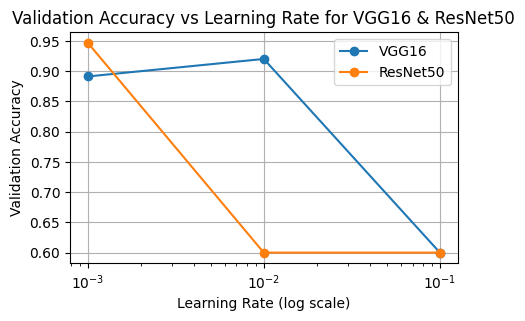

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

# Input shape and image size
img_size = (64, 64)
input_shape = img_size + (3,)

# Data preparation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set',
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes

# Function to build transfer learning model
def build_transfer_model(model_name):
    try:
        if model_name == 'VGG16':
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        elif model_name == 'ResNet50':
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        print(f"✅ Loaded {model_name} with pre-trained weights.")
    except:
        if model_name == 'VGG16':
            base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
        elif model_name == 'ResNet50':
            base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
        print(f"⚠️ Loaded {model_name} without pre-trained weights (offline mode).")

    base_model.trainable = False  # Freeze base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Evaluate models at different learning rates
results = []
learning_rates = [0.1, 0.01, 0.001]
models_to_test = ['VGG16', 'ResNet50']

for model_name in models_to_test:
    for lr in learning_rates:
        print(f"\n🔍 Training {model_name} at learning rate {lr}...")
        model = build_transfer_model(model_name)
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(train_generator, epochs=3, validation_data=val_generator, verbose=1)
        val_loss, val_acc = model.evaluate(val_generator, verbose=0)
        results.append((model_name, lr, val_acc))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Learning Rate', 'Validation Accuracy'])
print("\n📊 Results Table:\n", results_df)

# Plotting
plt.figure(figsize=(5, 3))
for model_name in models_to_test:
    subset = results_df[results_df['Model'] == model_name]
    plt.plot(subset['Learning Rate'], subset['Validation Accuracy'], marker='o', label=model_name)

plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate for VGG16 & ResNet50')
plt.legend()
plt.grid(True)
plt.show()
